# シンプルなFC層を用いたモデル（時間情報部分的にあり）

### 方針

・内部に問題ごとの依存関係を定義し、その関係をもとに遷移させる。

・条件付き確率（遷移確率）と周辺分布の積の和から次の周辺分布を求める。

・まずは遷移過程が部分的にしか分からない人工データを用意し、モデルを学習する。

### データの生成

・データの用意

In [1]:
import numpy as np

# 問題の依存関係の行列 A 
A = np.array([
    [0, 0, 0, 0, 0, 0],  # 初期状態
    [1, 0, 0, 0, 0, 0],  # 問題1は初期状態のみに依存
    [1, 0, 0, 0, 0, 0],  # 問題2は問題1に依存
    [0, 1, 1, 0, 0, 0],  # 問題3は問題2に依存
    [0, 0, 0, 1, 0, 0],  # 問題4は問題2、問題3に依存
    [0, 0, 0, 0, 1, 0]   # 問題4は問題2、問題3に依存
])


# 遷移確率を計算する関数
def calculate_transition_probabilities(A, X):
    n = len(X)
    raw_probabilities = np.zeros(n)  # 遷移確率の元となる値
    
    # 不正解の問題に対して遷移確率を計算
    for i in range(n):
        if X[i] == 0:  # 不正解の問題のみ計算
            required_problems = A[i, :]  # i番目の問題に必要な依存関係
            
            # # 依存関係がすべて0であるかを確認
            # if np.all(required_problems == 0):
            #     raw_probabilities[i] =  10  # 必要なら、この問題の遷移確率を設定
            #     continue
            
            solved_problems = X * required_problems  # 実際に解けた問題
            
            num_required = np.sum(required_problems)  # 必要な問題の数
            num_solved = np.sum(solved_problems)      # 実際に解けた問題の数
            
            if num_required > 0:
                raw_probabilities[i] = np.exp(num_solved / num_required)
    
    # 総和で割って正規化
    total_sum = np.sum(raw_probabilities)  # expの総和
    if total_sum > 0:  # 総和が0でなければ正規化
        probabilities = raw_probabilities / total_sum
    else:
        probabilities = raw_probabilities  # 総和が0ならそのまま
    
    return probabilities

In [2]:
# 教師データセットを生成する関数
def generate_training_data(A, initial_X, num_correct_problems, num_data_per_step):
    n = len(initial_X)  # 問題数
    dataset = []
    
    # 各ステップでデータを生成
    for i in range(1, num_correct_problems + 1):  # 正解させる問題数
        for j in range(num_data_per_step):  # 各ステップごとにデータ数
            X = initial_X.copy()  # 初期状態からスタート
            input_X = X.copy()
            # i問正解させる
            for k in range(i):

                probabilities = calculate_transition_probabilities(A, X)
                
                if np.sum(probabilities) > 0:  # 正規化された確率がある場合
                    # 確率に基づいて次に正解させる問題を選択
                    next_correct_problem = np.random.choice(n, p=probabilities)
                    X[next_correct_problem] = 1  # 選ばれた問題を正解に遷移させる
                
            # 初期状態と1ステップ後の状態の差分を教師データとして使用
            target_Y = (X - input_X).clip(min=0)  # 0から1に変わった部分のみを1、他は0
            print(f"input_X: {input_X}, target_Y: {target_Y}")
            # 初期状態（入力）と差分（教師データ）のペアを保存
            dataset.append((input_X.copy(), target_Y.copy()))  # (入力データ, 教師データ)
    return dataset


## モデル

### FCモデル

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class Model(nn.Module):
    def __init__(self, num_questions):
        super(Model, self).__init__()
        self.fc = nn.Linear(num_questions, num_questions)  # 全結合層

    def forward(self, x):
        x = self.fc(x)  # 全結合層の適用
        x = F.softmax(x, dim=1)  # ソフトマックスを適用
        return x

In [4]:
# データセットの生成
num_questions = 5  # 問題数
num_data_per_step = 10000     # 各ステップごとに生成するデータ数

# 生徒の回答状況 X (1が正解、0が不正解)
# 初期状態は全て不正解
X_init = np.array([1, 0, 0, 0, 0, 0])

training_data = generate_training_data(A, X_init, num_questions, num_data_per_step)

# PyTorch テンソルに変換
train_X = torch.tensor([input_data for input_data, _ in training_data], dtype=torch.float32)
train_Y = torch.tensor([target_data for _, target_data in training_data], dtype=torch.float32)

# モデル、損失関数、最適化関数の設定
model = Model(num_questions+1)  # 5問+初期状態の問題を扱うモデル
criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)  # L2正則化

input_X: [1 0 0 0 0 0], target_Y: [0 0 0 0 1 0]
input_X: [1 0 0 0 0 0], target_Y: [0 1 0 0 0 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 1 0 0 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 0 0 0 1]
input_X: [1 0 0 0 0 0], target_Y: [0 0 0 0 1 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 1 0 0 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 0 0 1 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 1 0 0 0]
input_X: [1 0 0 0 0 0], target_Y: [0 1 0 0 0 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 1 0 0 0]
input_X: [1 0 0 0 0 0], target_Y: [0 1 0 0 0 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 0 0 0 1]
input_X: [1 0 0 0 0 0], target_Y: [0 0 0 1 0 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 0 0 1 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 0 0 1 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 0 0 0 1]
input_X: [1 0 0 0 0 0], target_Y: [0 0 0 1 0 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 0 1 0 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 0 0 1 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 0 0 0 1]
input_X: [1 0 0 0 0 0], target_Y: [0 1 0

/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_58270/2939125051.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  train_X = torch.tensor([input_data for input_data, _ in training_data], dtype=torch.float32)


In [5]:
import itertools
from collections import defaultdict

# Generate states where the first digit is always 1
states = [(1,) + state for state in itertools.product([0, 1], repeat=num_questions)]
print(f"Number of States: {len(states)}\n")

# Initialize the state counts
state_counts = defaultdict(int)

# Assuming 'dataset' is your list of student results
for result, result2 in training_data:
    # print(result2)
    state_tuple = tuple(map(int, result + result2))  # Convert np.int64 to int
    state_counts[state_tuple] += 1  # Count only if the first digit is 1

print(state_counts)

# Display the counts for each state
for state in states:
    count = state_counts[state]
    formatted_state = list(state)  # Convert tuple to list for the desired format
    print(f"State {formatted_state}: {count} students")

print(state_counts)

Number of States: 32

defaultdict(<class 'int'>, {(1, 0, 0, 0, 1, 0): 1188, (1, 1, 0, 0, 0, 0): 3219, (1, 0, 1, 0, 0, 0): 3281, (1, 0, 0, 0, 0, 1): 1168, (1, 0, 0, 1, 0, 0): 1144, (1, 0, 0, 0, 1, 1): 479, (1, 1, 0, 1, 0, 0): 1248, (1, 1, 1, 0, 0, 0): 2697, (1, 1, 0, 0, 0, 1): 968, (1, 0, 1, 1, 0, 0): 1168, (1, 0, 1, 0, 1, 0): 852, (1, 1, 0, 0, 1, 0): 867, (1, 0, 1, 0, 0, 1): 950, (1, 0, 0, 1, 0, 1): 280, (1, 0, 0, 1, 1, 0): 491, (1, 1, 0, 0, 1, 1): 697, (1, 1, 1, 0, 0, 1): 1567, (1, 1, 1, 1, 0, 0): 2502, (1, 0, 1, 0, 1, 1): 732, (1, 1, 0, 1, 1, 0): 883, (1, 0, 1, 1, 1, 0): 870, (1, 1, 0, 1, 0, 1): 595, (1, 1, 1, 0, 1, 0): 1239, (1, 0, 1, 1, 0, 1): 549, (1, 0, 0, 1, 1, 1): 366, (1, 1, 1, 1, 0, 1): 2360, (1, 1, 1, 1, 1, 0): 3335, (1, 1, 0, 1, 1, 1): 1195, (1, 1, 1, 0, 1, 1): 1927, (1, 0, 1, 1, 1, 1): 1183, (1, 1, 1, 1, 1, 1): 10000})
State [1, 0, 0, 0, 0, 0]: 0 students
State [1, 0, 0, 0, 0, 1]: 1168 students
State [1, 0, 0, 0, 1, 0]: 1188 students
State [1, 0, 0, 0, 1, 1]: 479 students


## 学習

In [6]:
# 学習ループ
num_epochs = 3000  # エポック数
for epoch in range(num_epochs):
    model.train()  # モデルを訓練モードに
    optimizer.zero_grad()  # 勾配の初期化
    
    # モデルの予測
    outputs = model(train_X) # 1ステップの予測
    
    # 1. outputs * train_Y がゼロでないものをマスクする
    mask_train_Y = (train_Y != 0)  # 新たに習得した問題をTrue
    masked_train_Y = torch.exp(outputs * train_Y)[mask_train_Y]  # マスクされた要素のみ計算

    # 2. outputs * (1 - train_X) がゼロでないものをマスクする
    mask_train_X = (train_X == 0)  # まだ習得していない問題をTrue
    masked_train_X = torch.exp(outputs * (1 - train_X))[mask_train_X]  # マスクされた要素のみ計算

    # 3. マスクされた要素で sum を計算
    numerator = torch.sum(masked_train_Y)
    denominator = torch.sum(masked_train_X)

    # 4. 最終的な probability を計算
    # 現在解けていない問題のうち、Vに含まれる問題から確率を求める
    probability = numerator / denominator

    # 損失関数の設定：probabilityを最大化したいので、負の対数尤度を使用
    loss = -torch.log(probability)
    
    # バックプロパゲーションとパラメータの更新
    loss.backward()
    optimizer.step()
    
    # 100エポックごとに損失を表示
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 学習結果の確認
print("Training complete!")

Epoch [500/3000], Loss: 0.4689
Epoch [1000/3000], Loss: 0.4688
Epoch [1500/3000], Loss: 0.4688
Epoch [2000/3000], Loss: 0.4688
Epoch [2500/3000], Loss: 0.4688
Epoch [3000/3000], Loss: 0.4688
Training complete!


## テスト

In [7]:
test = np.array([[1, 0, 0, 0, 0, 0]], dtype=np.float32)

# numpy配列をtorch.Tensorに変換
test_tensor = torch.tensor(test, dtype=torch.float32)

model.eval()  # モデルを評価モードに

# モデルに入力を渡して出力を得る
output = model(test_tensor)
print("Output:", output)

Output: tensor([[0.0077, 0.9634, 0.0094, 0.0068, 0.0064, 0.0062]],
       grad_fn=<SoftmaxBackward0>)


In [8]:
# モデルの各パラメータを表示
for param in model.parameters():
    print(param)

print("結果\n", A)

Parameter containing:
tensor([[-3.7416e-01,  1.5825e-41, -1.6860e-41,  7.1454e-41, -1.5675e-41,
         -4.4309e-42],
        [ 2.0384e+00,  1.0161e-39,  3.9292e-42,  7.3956e-41,  6.0942e-41,
         -6.2365e-41],
        [-2.7621e-01,  5.0224e-41, -2.5434e-42, -7.0146e-41, -1.3715e-41,
          2.8786e-40],
        [-4.3493e-01, -6.6740e-41,  4.5528e-41,  2.1238e-41,  6.1263e-41,
          2.0324e-40],
        [-4.6632e-01, -1.2627e-41,  9.1785e-42, -2.0385e-41, -2.6672e-41,
          3.7671e-41],
        [-4.8644e-01, -3.3994e-41,  9.0347e-40,  9.0216e-42, -4.6677e-42,
          2.9251e-39]], requires_grad=True)
Parameter containing:
tensor([-0.3743,  2.0381, -0.2762, -0.4349, -0.4664, -0.4864],
       requires_grad=True)
結果
 [[0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]]


・図示

State: (1, 0, 0, 0, 0, 0), Probabilities: [0.         0.32220249 0.32220249 0.11853167 0.11853167 0.11853167], Predicted Values: tensor([[0.0077, 0.9634, 0.0094, 0.0068, 0.0064, 0.0062]],
       grad_fn=<SoftmaxBackward0>)
State: (1, 0, 0, 0, 0, 1), Probabilities: [0.         0.36552929 0.36552929 0.13447071 0.13447071 0.        ], Predicted Values: tensor([[0.0077, 0.9634, 0.0094, 0.0068, 0.0064, 0.0062]],
       grad_fn=<SoftmaxBackward0>)
State: (1, 0, 0, 0, 1, 0), Probabilities: [0.         0.29692274 0.29692274 0.10923177 0.         0.29692274], Predicted Values: tensor([[0.0077, 0.9634, 0.0094, 0.0068, 0.0064, 0.0062]],
       grad_fn=<SoftmaxBackward0>)
State: (1, 0, 0, 0, 1, 1), Probabilities: [0.        0.4223188 0.4223188 0.1553624 0.        0.       ], Predicted Values: tensor([[0.0077, 0.9634, 0.0094, 0.0068, 0.0064, 0.0062]],
       grad_fn=<SoftmaxBackward0>)
State: (1, 0, 0, 1, 0, 0), Probabilities: [0.         0.29692274 0.29692274 0.         0.29692274 0.10923177], Pre

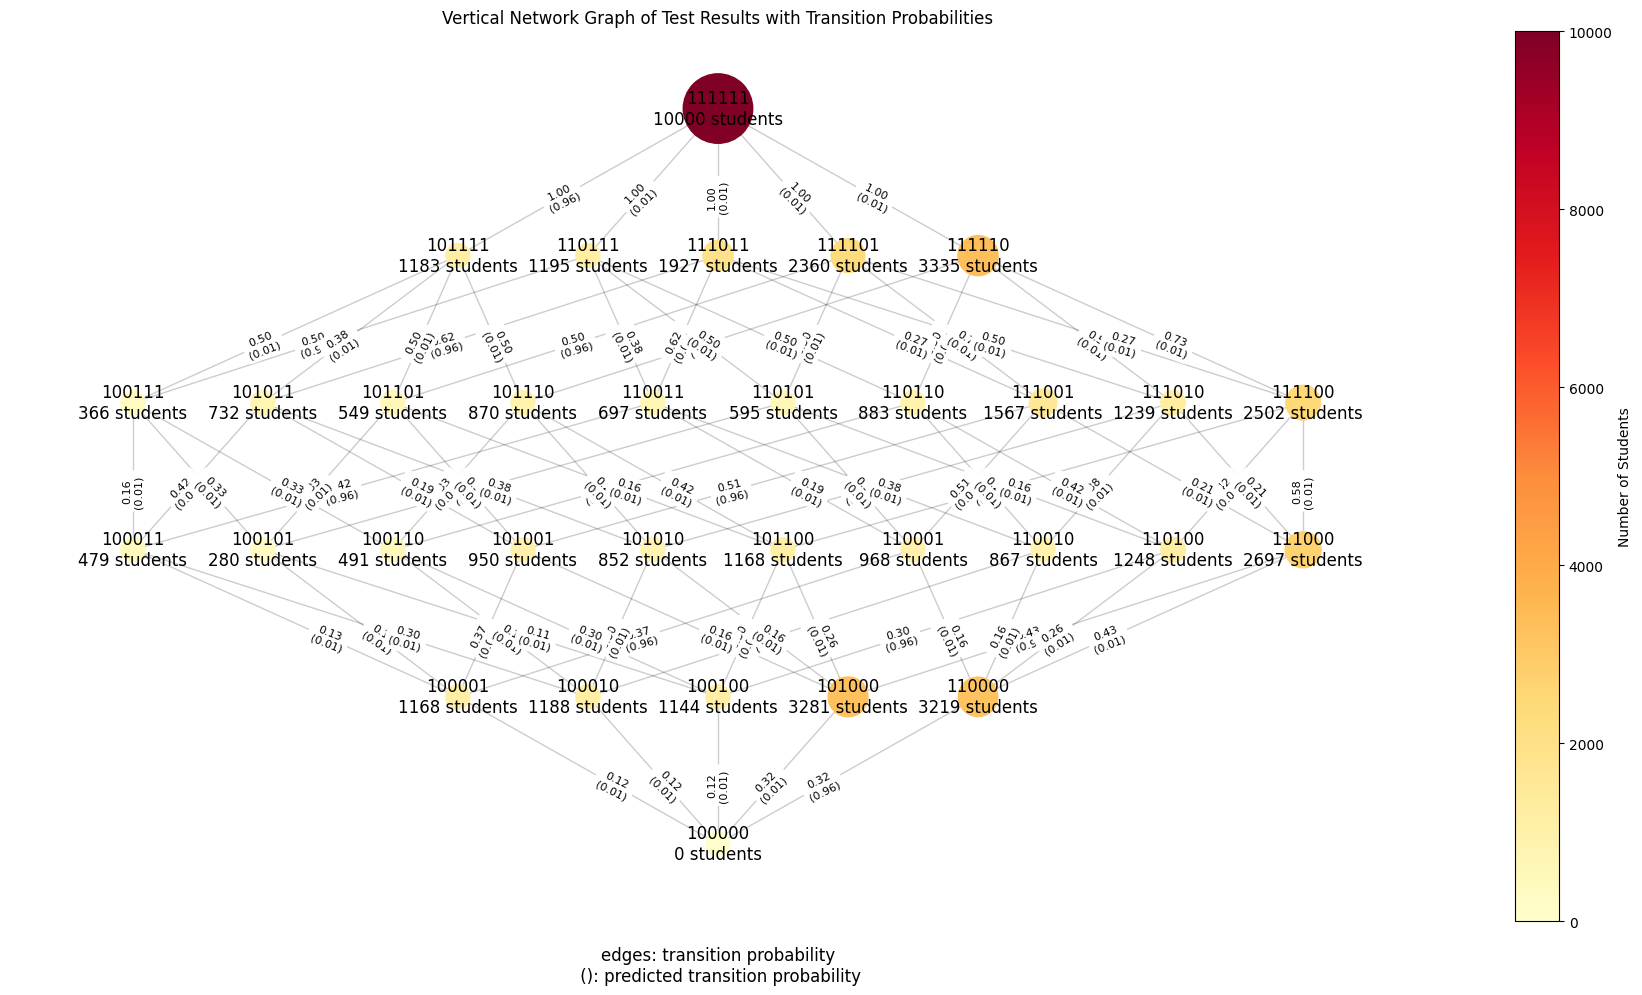

State counts:
State 100000: 0 students
State 100010: 1188 students
State 110000: 3219 students
State 101000: 3281 students
State 100001: 1168 students
State 100100: 1144 students
State 100011: 479 students
State 110100: 1248 students
State 111000: 2697 students
State 110001: 968 students
State 101100: 1168 students
State 101010: 852 students
State 110010: 867 students
State 101001: 950 students
State 100101: 280 students
State 100110: 491 students
State 110011: 697 students
State 111001: 1567 students
State 111100: 2502 students
State 101011: 732 students
State 110110: 883 students
State 101110: 870 students
State 110101: 595 students
State 111010: 1239 students
State 101101: 549 students
State 100111: 366 students
State 111101: 2360 students
State 111110: 3335 students
State 110111: 1195 students
State 111011: 1927 students
State 101111: 1183 students
State 111111: 10000 students


In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create the graph
G = nx.Graph()

# Add nodes with the 'count' attribute
for state in states:
    G.add_node(state, count=state_counts[state])

# Add edges between states
for state in states:
    for i in range(num_questions+1):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                G.add_edge(state, next_state)

# Custom layout function with uniform horizontal placement and centered nodes
def custom_layout(G, num_questions):
    pos = {}
    # Group nodes by their level (number of 1's in the state)
    levels = {}
    for state in G.nodes():
        level = sum(state)  # Level is the number of 1's in the state
        if level not in levels:
            levels[level] = []
        levels[level].append(state)
    
    # Determine the x and y positions for each node
    for level, states_at_level in levels.items():
        num_nodes_at_level = len(states_at_level)
        for i, state in enumerate(sorted(states_at_level)):
            # x position is evenly spaced horizontally for each level
            x = i - (num_nodes_at_level - 1) / 2  # Center horizontally
            y = level  # y position is the level itself (number of 1's)
            pos[state] = (x, y)
    
    return pos


# Apply the custom layout
pos = custom_layout(G, num_questions)

# Normalize x positions
x_values = [pos[node][0] for node in pos]
min_x, max_x = min(x_values), max(x_values)
for node in pos:
    x, y = pos[node]
    x_norm = (x - min_x) / (max_x - min_x)
    pos[node] = (x_norm, y)

# Plot settings
plt.figure(figsize=(18, 10))  # Adjust the figure size as needed

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Adjust node sizes according to the number of students
node_sizes = []
for node in G.nodes():
    count = G.nodes[node]['count']
    size = max(300, min(6000, count/4))  # Increase the minimum size to 600
    node_sizes.append(size)


# Node colors based on the number of students
node_colors = [G.nodes[node]['count'] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.YlOrRd
)

# Create labels including the student counts
labels = {
    node: f"{''.join(map(str, node))}\n{G.nodes[node]['count']} students"
    for node in G.nodes()
}

# Transition probabilities: add labels to edges, including predicted values
edge_labels = {}
for state in states:
    probabilities = calculate_transition_probabilities(A, np.array(state))
    predicted_values = output = model(torch.tensor([state], dtype=torch.float32))  # 予測値を計算
    print(f"State: {state}, Probabilities: {probabilities}, Predicted Values: {predicted_values}")

    for i in range(num_questions+1):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                # 遷移確率と予測値をラベルに追加
                transition_probability = f"{probabilities[i]:.2f}"
                predicted_value = f"({predicted_values[0][i]:.2f})"  # 予測値を表示
                edge_labels[(state, next_state)] = f"{transition_probability}\n{predicted_value}"


# Draw node labels
nx.draw_networkx_labels(G, pos, labels, font_size=12)
# Draw edge labels with transition probabilities
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.6)

# カラーバーの追加
plt.colorbar(nodes, label='Number of Students')

# グラフ描画の最後にコメントを追加
plt.text(
    0.5, -0.05,  # テキストの位置 (x, y)。x=0.5 は中央、y=1.05 はグラフの上
    "edges: transition probability\n (): predicted transition probability",  # 表示したいテキスト
    horizontalalignment='center',  # テキストの水平方向の配置（中央揃え）
    verticalalignment='center',    # テキストの垂直方向の配置（中央揃え）
    transform=plt.gca().transAxes,  # Axes の座標系で位置を指定 (0-1の範囲)
    fontsize=12,                    # フォントサイズ
    color="black"                   # テキストの色
)

plt.title('Vertical Network Graph of Test Results with Transition Probabilities')
plt.axis('off')
plt.tight_layout()

# Display the graph
plt.show()

# Print the state counts
print("State counts:")
for state, count in sorted(state_counts.items(), key=lambda x: sum(x[0])):
    print(f"State {''.join(map(str, state))}: {count} students")